In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [7]:
data = pd.read_csv('../data/datadaily/data_daily0.csv', index_col='Date_time_nr')
data_ml = feature_pipeline(data)


In [4]:
#### lag featuring

def df_to_X_y(data, window_size=2):
    df_as_np = data.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][-1]
        y.append(label)
    return np.array(X), np.array(y)
    
def add_yearly_fourier(df): 
    ts = pd.to_datetime(df.index) 
    day_of_year = ts.dayofyear 
    T = 365.25 
    df = df.copy() 
    df["year_sin"] = np.sin(2 * np.pi * day_of_year / T) 
    df["year_cos"] = np.cos(2 * np.pi * day_of_year / T) 
    return df 

def encode_wind_direction_circular(df): 
    df = df.copy() 
    theta = np.deg2rad(df["wind_deg"] % 360) 
    df["wind_sin"] = np.sin(theta) 
    df["wind_cos"] = np.cos(theta)
    df.drop(columns=["wind_deg"], inplace=True) 
    return df 

def feature_pipeline(df):
    if 'P_avg' in df.columns:
        df_X = df.drop(columns=['P_avg'])
        df_y = df['P_avg']
        df_X = encode_wind_direction_circular(df_X) 
        df_X = add_yearly_fourier(df_X) 
        df = pd.concat([df_X, df_y], axis=1)
        return df
    
    else:
        df = encode_wind_direction_circular(df) 
        df = add_yearly_fourier(df) 
        return df

In [5]:
X, y = df_to_X_y(data_ml)

X.shape, y.shape

((1824, 2, 11), (1824,))

In [6]:
def split_data(X, y):
    X_train , y_train = X[ : 1459], y[ :1459 ]
    X_val, y_val = X[1459: ], y[1459: ]
    return X_train, y_train, X_val, y_val

X_train, y_train, X_val, y_val = split_data(X, y)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1459, 2, 11), (1459,), (365, 2, 11), (365,))

In [7]:
#plot function

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

import keras
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Conv1D, Flatten
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [13]:
def create_model():
    model = Sequential([
        InputLayer(shape=(2,11))
        , Conv1D(64, kernel_size=2, activation='relu')
        , Flatten()
        , Dense(8, 'relu')
        , Dense(1, 'linear')
    ])
    
    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss="mse"
        , optimizer=opt
        , metrics=[keras.metrics.RootMeanSquaredError()]
        )

    return model

model = create_model()

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 64)          │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,001 (7.82 KB)

 Trainable params: 2,001 (7.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp = ModelCheckpoint('models/model1.keras', save_best_only=True)
model.fit(
    X_train, y_train
    , validation_data= (X_val, y_val)
    , epochs = 20
    , callbacks=[cp]
)

In [18]:
model.predict(X_val).flatten().shape, y_val.shape

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


((365,), (365,))

In [19]:
X_val.shape

(365, 2, 11)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


<Axes: >

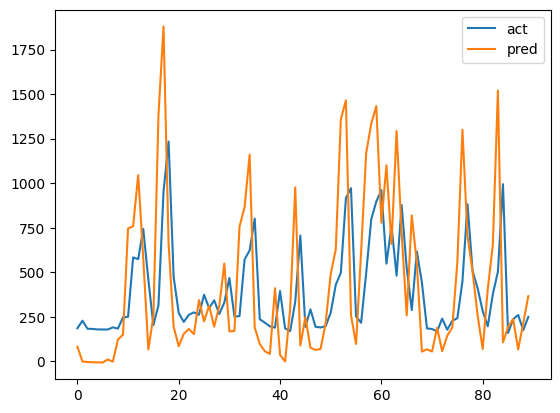

In [27]:
from utils.model_utils import predict
model = load_model('models/model1.keras')

data_plot = pd.DataFrame({
    'act' : model.predict(X_val).flatten()
    ,'pred' : y_val
}) 
data_plot[:90].plot()

In [2]:
from utils.model_utils import predict
model = load_model('models/model1.keras')


In [28]:
data.shape, data_ml.shape

((1826, 8), (1826, 11))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


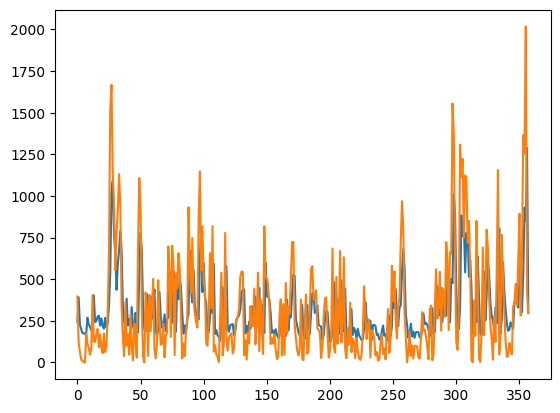

In [9]:
plt.plot(model.predict(df_to_X_y(data_ml[:360])[0]))
plt.plot(df_to_X_y(data_ml[:360])[1])

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


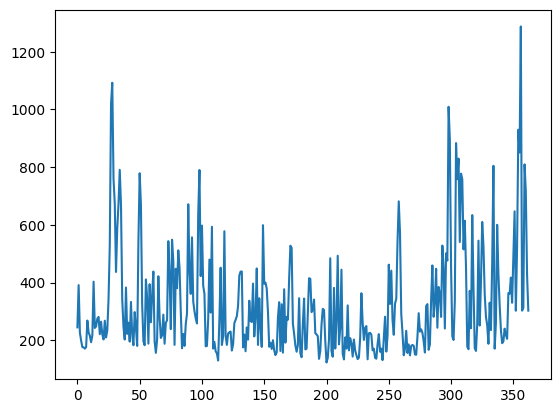

In [46]:
def predictions(data):
    data_ml = feature_pipeline(data)
    X  = df_to_X_y(data_ml)[0]
    array = model.predict(X)
    return array

plt.plot(predictions(data[:365]))
plt.plot(data['P_avg'].loc[:365]) 

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


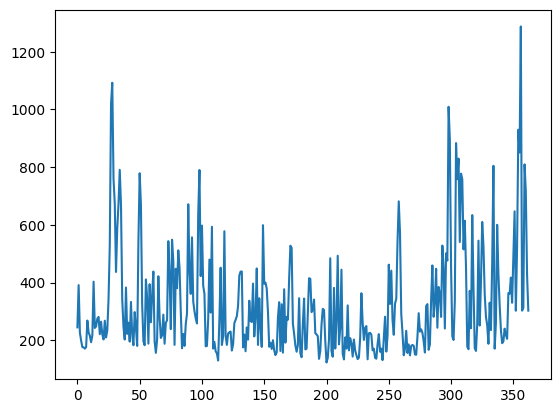

In [51]:
plt.plot(predictions(data[:365]))
#plt.plot(data['P_avg'].iloc[:365]) 

In [15]:
data1 =  pd.read_json('../data/json/jdata1.json', orient='split')
data1

,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_1h,P_avg
2017-01-01,-2.175833,1022.666667,99.416667,2.250000,206.250000,0.000000,0.000000,82.372778
2017-01-02,-0.355000,1023.583333,100.000000,2.443333,238.333333,0.000000,0.028333,-0.761458
2017-01-03,-1.379583,1027.500000,98.833333,2.591250,213.500000,0.000000,0.000000,-3.422986
2017-01-04,0.083333,1022.041667,100.000000,5.444583,277.916667,0.020833,0.009167,-4.777014
2017-01-05,-0.537083,1029.708333,87.916667,3.065417,168.750000,0.000000,0.000000,-5.425347
...,...,...,...,...,...,...,...,...
2017-12-27,4.732500,988.875000,89.375000,7.052500,210.416667,0.290000,0.000000,1092.846736
2017-12-28,1.176667,1004.333333,88.500000,4.544583,252.083333,0.000000,0.000000,421.928542
2017-12-29,2.014583,1008.083333,88.500000,6.686250,202.083333,0.009583,0.034167,854.138889
2017-12-30,9.525833,1008.416667,93.208333,7.674167,216.250000,0.520417,0.000000,1435.234931


In [16]:
def predictions(data):
    data_ml = feature_pipeline(data)
    X  = df_to_X_y(data_ml)[0]
    array = model.predict(X)
    return array


In [17]:
predictions(data1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


array([[ 183.22603],
       [ 182.23772],
       [ 179.3141 ],
       [ 179.18254],
       [ 179.20055],
       [ 191.05934],
       [ 184.30685],
       [ 246.98769],
       [ 250.09013],
       [ 583.8406 ],
       [ 573.65173],
       [ 743.22424],
       [ 460.38083],
       [ 203.73   ],
       [ 314.80737],
       [ 952.41815],
       [1234.3159 ],
       [ 473.34567],
       [ 271.7163 ],
       [ 221.75487],
       [ 261.42322],
       [ 275.04712],
       [ 261.68152],
       [ 374.0622 ],
       [ 299.5475 ],
       [ 343.13467],
       [ 265.3873 ],
       [ 330.07724],
       [ 468.26935],
       [ 250.8799 ],
       [ 254.36497],
       [ 572.18756],
       [ 622.9312 ],
       [ 801.3397 ],
       [ 236.35753],
       [ 217.45528],
       [ 196.3492 ],
       [ 189.45276],
       [ 395.1326 ],
       [ 185.11604],
       [ 169.98497],
       [ 334.58282],
       [ 706.2126 ],
       [ 193.98317],
       [ 291.96097],
       [ 194.42122],
       [ 190.26932],
       [ 197.

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


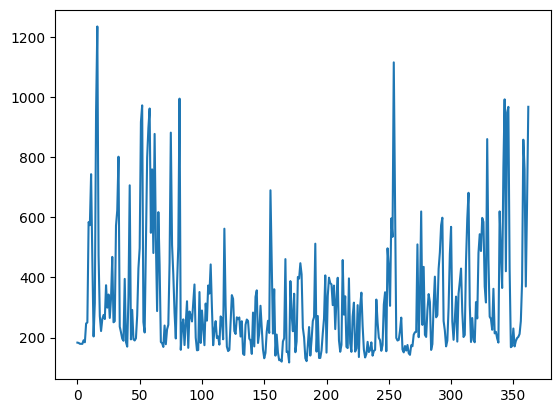

In [18]:
plt.plot(predictions(data1))

In [21]:
datadb1 = data.head()
datadb1.to_json(path_or_buf='../data/json/jdatadb1.json', index=True, orient='split')